In [5]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [9]:
def catheter_mesh_1d(Lx, x2, x3, h, ncx1, ncx2, ncx3, ncx4):
    x1 = 0.4*Lx
    # ncy = 20
    
    Ly = 20

    # ncx1, ncx2, ncx3, ncx4 = 20, 10, 10, 20
    ncx = ncx1 + ncx2 + ncx3 + ncx4
    
    xx = torch.zeros(ncx+1, dtype=torch.float).to(device)
    xx_ref = torch.linspace(0, 1-1/ncx1, ncx1)
    xx[0:ncx1] = 0*(1 - xx_ref) + (x1 - x1/ncx1)*xx_ref 
    xx_ref = torch.linspace(0, 1-1/ncx2, ncx2)
    xx[ncx1:ncx1+ncx2] = x1*(1 - xx_ref) + ((x1+x3)/2) * xx_ref
    xx_ref = torch.linspace(0, 1-1/ncx3, ncx3)
    xx[ncx1+ncx2:ncx1+ncx2+ncx3] = (x1+x3)/2*(1 - xx_ref) + x3 * xx_ref
    xx_ref = torch.linspace(0, 1, ncx4+1)
    xx[ncx1+ncx2+ncx3:ncx1+ncx2+ncx3+ncx4+1] = x3*(1 - xx_ref) + Lx*xx_ref
    
    yy = torch.zeros(ncx+1, dtype=torch.float).to(device)
    yy[ncx1:ncx1+ncx2] = (xx[ncx1:ncx1+ncx2] - x1)/((x1+x3)/2 - x1)*h
    yy[ncx1+ncx2:ncx1+ncx2+ncx3+1] = (x3 - xx[ncx1+ncx2:ncx1+ncx2+ncx3+1])/(x3 - (x1+x3)/2)*h
    

    dx1 = torch.zeros(ncx+1, dtype=torch.float).to(device)
    dx2 = torch.zeros(ncx+1, dtype=torch.float).to(device)
    dx = torch.zeros(ncx+1, dtype=torch.float).to(device)
    dx1[0:ncx1+ncx2+1] = (x1+x3)/2 
    dx2[0:ncx1+ncx2+1] = x1
    dx1[ncx1+ncx2:] = Lx-(x1+x3)/2
    dx2[ncx1+ncx2:] = Lx-x3

    dx[ncx1+1:ncx1+ncx2] = xx[ncx1+1:ncx1+ncx2]
    dx[ncx1+ncx2:ncx1+ncx2+ncx3+1] = Lx - xx[ncx1+ncx2:ncx1+ncx2+ncx3+1]

    Delta_x_max = x2 - (x1 + x3)/2

    Delta_x = dx/(dx1*yy + (h - yy)*dx2) * yy * Delta_x_max
    
    xx = xx + Delta_x
    
    n_periods = 4
    X_Y = torch.zeros((1, n_periods*ncx+1, 2), dtype=torch.float).to(device)
    X_Y[0, -(ncx + 1):, 0], X_Y[0, -(ncx + 1):, 1] = xx, yy
    for i_period in range(1,n_periods):
        X_Y[0, -((i_period + 1)*ncx + 1):-(i_period*ncx), 0], X_Y[0, -((i_period + 1)*ncx + 1):-(i_period*ncx), 1] = xx-i_period*100, yy
       
    
    return X_Y, xx, yy


def Theta2Mesh_1d(Lx, x2, x3, h):
    ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50
    X_Y, X, Y = catheter_mesh_1d(Lx, x2, x3, h, ncx1, ncx2, ncx3, ncx4)
    return X_Y, X, Y

1d X error =  7.010847012314653
1d Y error =  0.0


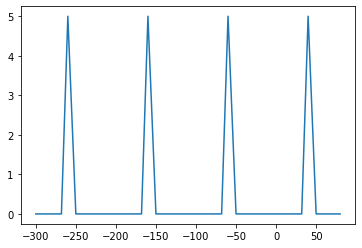

In [10]:
Lx, x2, x3, h = 80, 40, 50, 5
ncx1, ncx2, ncx3, ncx4 = 5, 2, 2, 5
X0,Y0 = numpy_catheter_mesh_1d(Lx, x2, x3, h, ncx1, ncx2, ncx3, ncx4, plot_or_not = False)
X_Y, X, Y = catheter_mesh_1d(Lx, x2, x3, h, ncx1, ncx2, ncx3, ncx4)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))

X_Y = X_Y.cpu().numpy()
plt.plot(X_Y[0, :, 0], X_Y[0, :, 1])

5326337
0 0.019018959254026413 loss =  16122284.0 reg =  2500000.0
Lx, x2, x3, h =  45.0 50.0 2.5


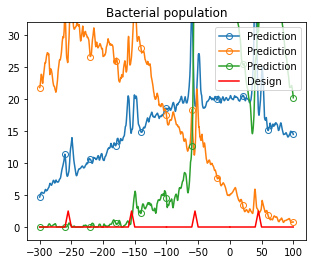

200 0.015992285683751106 loss =  4524789.5 reg =  5670846.745585025
Lx, x2, x3, h =  46.812403127519104 46.233375692496224 5.670846745585025


<Figure size 432x288 with 0 Axes>

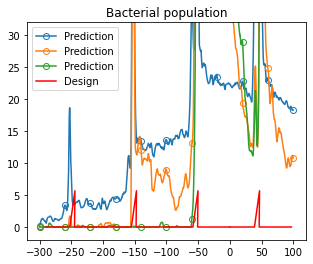

400 0.014898891560733318 loss =  2210558.0 reg =  8477643.275976364
Lx, x2, x3, h =  48.62735113491725 43.80839263832637 8.477643275976364


<Figure size 432x288 with 0 Axes>

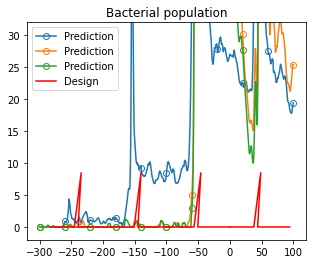

600 0.015339398756623268 loss =  1444586.375 reg =  10008112.213510357
Lx, x2, x3, h =  50.0716438221947 45.172069696527586 10.008112213510357


<Figure size 432x288 with 0 Axes>

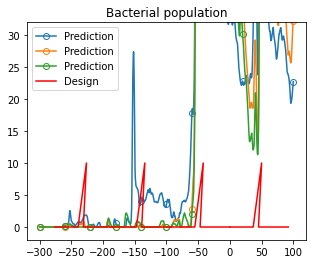

800 0.015393546782433987 loss =  404392.875 reg =  10482128.621194765
Lx, x2, x3, h =  51.25224842975278 47.84020440359119 10.482128621194764


<Figure size 432x288 with 0 Axes>

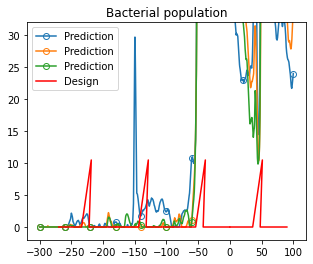

1000 0.015937856398522854 loss =  -279077.625 reg =  9484847.12139753
Lx, x2, x3, h =  52.270169356802526 51.20115720042388 9.48484712139753


<Figure size 432x288 with 0 Axes>

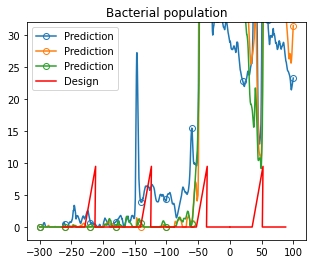

1200 0.01587485894560814 loss =  -169261.65625 reg =  8380405.099862798
Lx, x2, x3, h =  52.71599235513763 52.85252837289299 8.380405099862799


<Figure size 432x288 with 0 Axes>

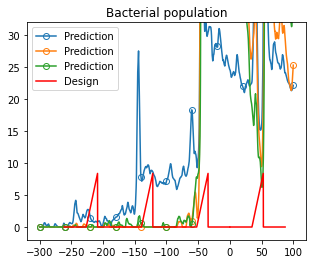

1400 0.015635761432349682 loss =  596161.9375 reg =  6904445.468778717
Lx, x2, x3, h =  53.217106541695415 54.198149916332184 6.904445468778717


<Figure size 432x288 with 0 Axes>

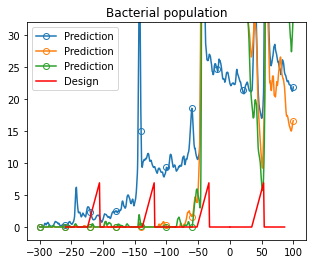

1600 0.015782278962433338 loss =  1653040.625 reg =  5285143.101484046
Lx, x2, x3, h =  53.87475300237454 55.0969662375162 5.285143101484047


<Figure size 432x288 with 0 Axes>

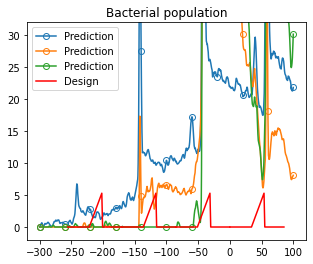

1800 0.015677234157919884 loss =  2694024.0 reg =  3781507.410443443
Lx, x2, x3, h =  54.734654869042714 55.717281856305036 3.7815074104434427


<Figure size 432x288 with 0 Axes>

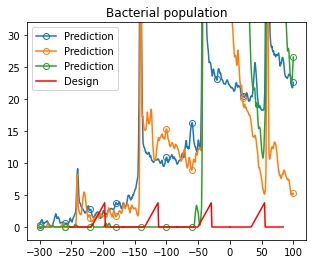

2000 0.018317081965506077 loss =  3710280.0 reg =  2639153.2314078226
Lx, x2, x3, h =  55.74716608159042 56.03583630595457 2.6391532314078225


<Figure size 432x288 with 0 Axes>

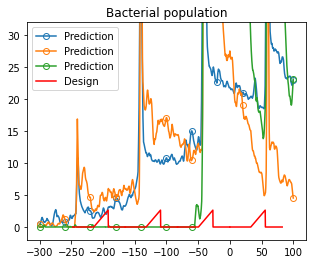

2200 0.01511701662093401 loss =  3807948.5 reg =  2280336.575992603
Lx, x2, x3, h =  56.26725466721936 56.01826889236797 2.280336575992603


<Figure size 432x288 with 0 Axes>

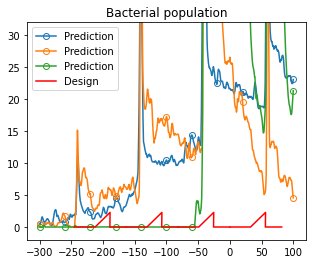

2400 0.01673725340515375 loss =  3608988.0 reg =  2106372.259169599
Lx, x2, x3, h =  56.77093251671765 55.85002877909227 2.106372259169599


<Figure size 432x288 with 0 Axes>

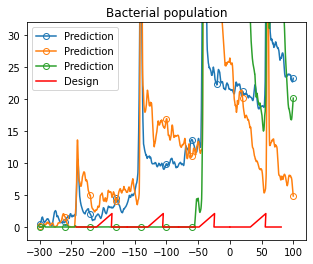

2600 0.017583738081157207 loss =  3201612.0 reg =  2098110.992665289
Lx, x2, x3, h =  57.25103927079519 55.53104330175063 2.0981109926652888


<Figure size 432x288 with 0 Axes>

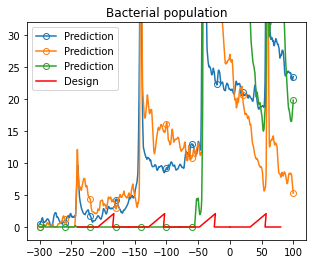

2800 0.015424932353198528 loss =  2677564.75 reg =  2231821.7402031836
Lx, x2, x3, h =  57.7030351254633 55.05554708937518 2.2318217402031837


<Figure size 432x288 with 0 Axes>

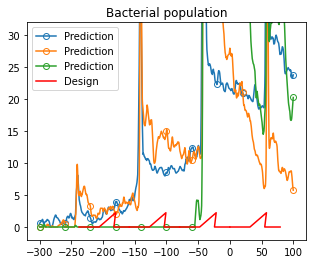

3000 0.01520405150949955 loss =  2151811.5 reg =  2446765.6709734215
Lx, x2, x3, h =  58.12578355592227 54.41923556563899 2.4467656709734213


<Figure size 432x288 with 0 Axes>

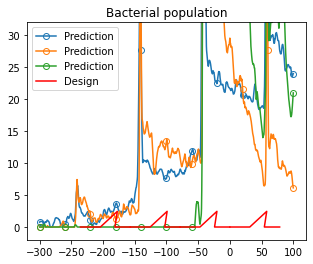

3200 0.01602461375296116 loss =  1914528.375 reg =  2560202.9211540893
Lx, x2, x3, h =  58.3246656617149 54.03900436406215 2.5602029211540893


<Figure size 432x288 with 0 Axes>

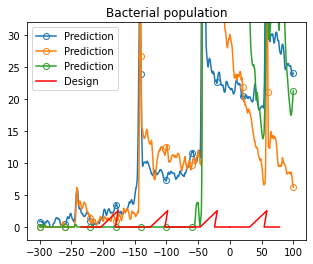

3400 0.014624137431383133 loss =  1706098.125 reg =  2665186.59653481
Lx, x2, x3, h =  58.51345519446161 53.61305664948017 2.66518659653481


<Figure size 432x288 with 0 Axes>

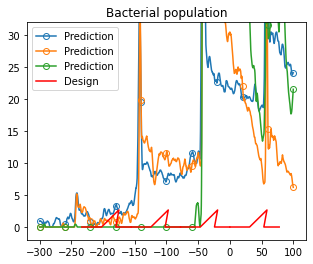

3600 0.017878747545182705 loss =  1568167.375 reg =  2736430.291106592
Lx, x2, x3, h =  58.69421384023279 53.17350562852782 2.736430291106592


<Figure size 432x288 with 0 Axes>

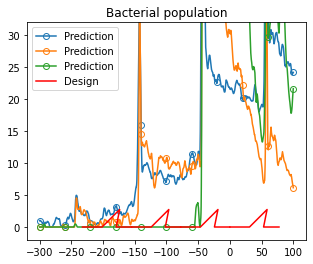

3800 0.016340576112270355 loss =  1506574.5 reg =  2741443.413486096
Lx, x2, x3, h =  58.868285719994034 52.7340143730472 2.741443413486096


<Figure size 432x288 with 0 Axes>

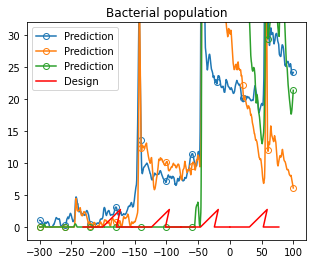

4000 0.015024561434984207 loss =  1535846.875 reg =  2650584.9210999063
Lx, x2, x3, h =  59.03701590017802 52.31013595149887 2.6505849210999064


<Figure size 432x288 with 0 Axes>

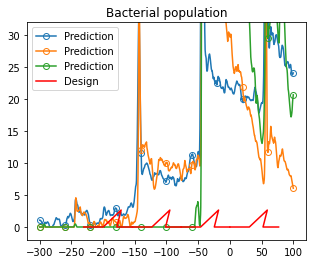

4200 0.016431809403002262 loss =  1603720.75 reg =  2547897.6432657344
Lx, x2, x3, h =  59.11923174189621 52.108212709150436 2.5478976432657343


<Figure size 432x288 with 0 Axes>

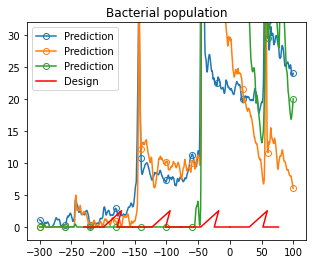

4400 0.016208596527576447 loss =  1710879.125 reg =  2395859.3026005737
Lx, x2, x3, h =  59.199623503481796 51.914825203235665 2.3958593026005737


<Figure size 432x288 with 0 Axes>

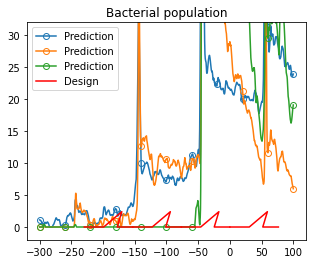

4600 0.015300762839615345 loss =  1846748.375 reg =  2218924.424729947
Lx, x2, x3, h =  59.278356301856235 51.726156023021986 2.218924424729947


<Figure size 432x288 with 0 Axes>

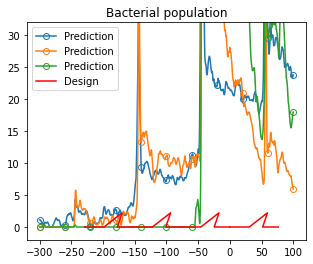

4800 0.01515258476138115 loss =  1996040.875 reg =  2035272.0349329321
Lx, x2, x3, h =  59.35576728678238 51.54188559477689 2.035272034932932


<Figure size 432x288 with 0 Axes>

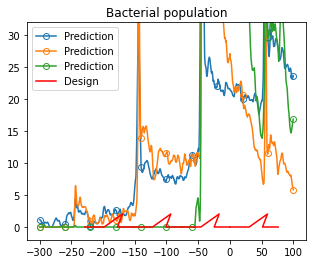

5000 0.016142417676746845 loss =  2152771.75 reg =  1857517.1259281454
Lx, x2, x3, h =  59.43222319508847 51.36680185814127 1.8575171259281453


<Figure size 432x288 with 0 Axes>

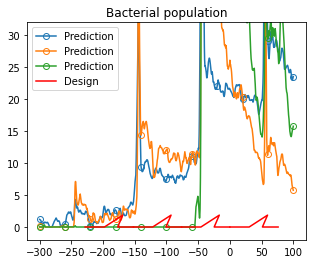

5200 0.01686989702284336 loss =  2222385.75 reg =  1772925.8561454432
Lx, x2, x3, h =  59.47008999323279 51.281671598053485 1.772925856145443


<Figure size 432x288 with 0 Axes>

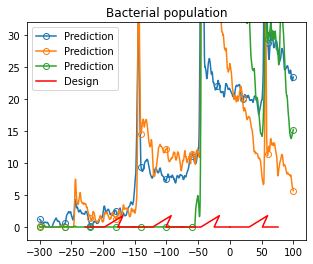

5400 0.015005835331976414 loss =  2288738.5 reg =  1693197.0567708171
Lx, x2, x3, h =  59.50767571577796 51.194177385054815 1.6931970567708172


<Figure size 432x288 with 0 Axes>

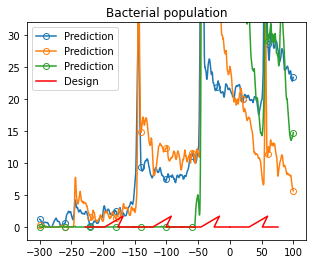

5600 0.018515084870159626 loss =  2352076.5 reg =  1618643.30612612
Lx, x2, x3, h =  59.545084068461634 51.10530433216067 1.61864330612612


<Figure size 432x288 with 0 Axes>

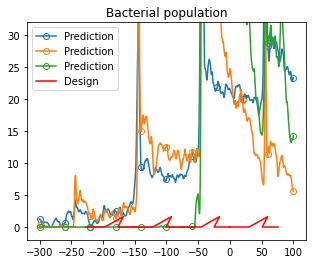

5800 0.016284575685858727 loss =  2412629.0 reg =  1548865.3162543206
Lx, x2, x3, h =  59.58238658087829 51.01594701240992 1.5488653162543207


<Figure size 432x288 with 0 Axes>

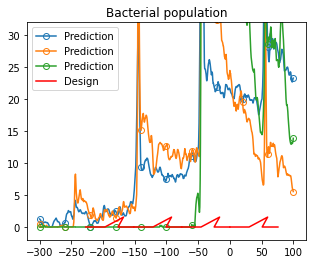

6000 0.01580558903515339 loss =  2469881.0 reg =  1483868.0075171026
Lx, x2, x3, h =  59.61967623945063 50.92722620058298 1.4838680075171027


<Figure size 432x288 with 0 Axes>

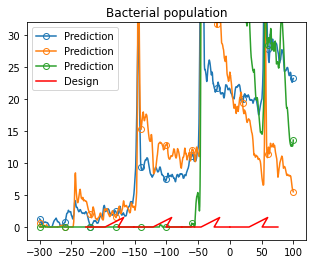

6200 0.015754698775708675 loss =  2496389.0 reg =  1453787.7812269651
Lx, x2, x3, h =  59.638338077080554 50.88341070295391 1.453787781226965


<Figure size 432x288 with 0 Axes>

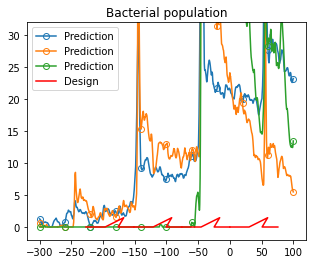

6400 0.015842790715396404 loss =  2520315.5 reg =  1426067.4085388705
Lx, x2, x3, h =  59.65702400746363 50.840000050859025 1.4260674085388705


<Figure size 432x288 with 0 Axes>

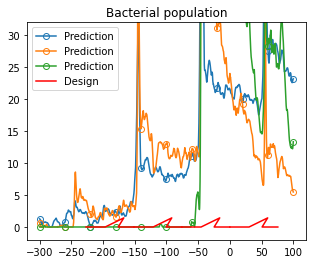

6600 0.017594678327441216 loss =  2542076.0 reg =  1400835.3109583966
Lx, x2, x3, h =  59.67574031554154 50.796992323073624 1.4008353109583966


<Figure size 432x288 with 0 Axes>

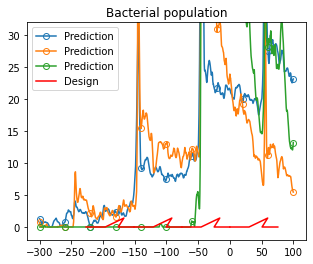

6800 0.017053534276783466 loss =  2560724.0 reg =  1378307.8849075597
Lx, x2, x3, h =  59.694491541613175 50.754440248141236 1.3783078849075596


<Figure size 432x288 with 0 Axes>

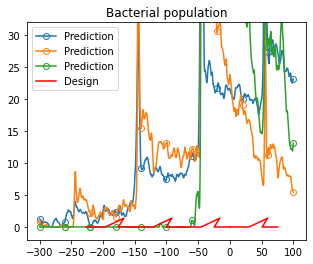

7000 0.015111738815903664 loss =  2575881.0 reg =  1358712.3173211722
Lx, x2, x3, h =  59.71328089471407 50.71185063454082 1.3587123173211721


<Figure size 432x288 with 0 Axes>

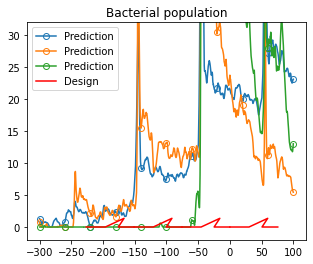

7200 0.018797675147652626 loss =  2581559.5 reg =  1350607.5406824534
Lx, x2, x3, h =  59.72269589163186 50.69039892454576 1.3506075406824534


<Figure size 432x288 with 0 Axes>

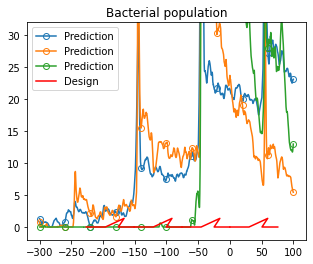

7400 0.015622860752046108 loss =  2585060.25 reg =  1344499.518678053
Lx, x2, x3, h =  59.73213064153143 50.66880024743117 1.344499518678053


<Figure size 432x288 with 0 Axes>

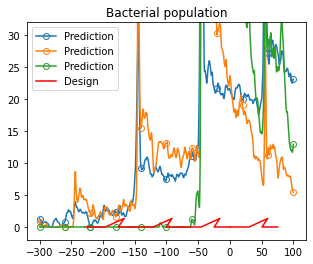

7600 0.01752587128430605 loss =  2585711.5 reg =  1340793.1699509649
Lx, x2, x3, h =  59.741583427972856 50.646997305390634 1.3407931699509648


<Figure size 432x288 with 0 Axes>

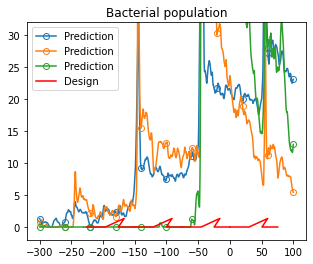

7800 0.015018031001091003 loss =  2582800.0 reg =  1340009.0537820968
Lx, x2, x3, h =  59.75105031468728 50.62470401344894 1.3400090537820968


<Figure size 432x288 with 0 Axes>

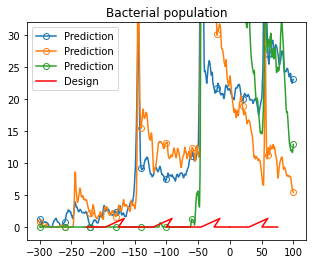

8000 0.014392553828656673 loss =  2575668.5 reg =  1342684.8646947236
Lx, x2, x3, h =  59.760526456345346 50.60159536767956 1.3426848646947236


<Figure size 432x288 with 0 Axes>

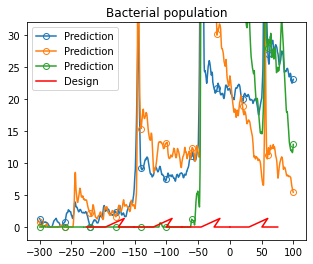

8200 0.015501872636377811 loss =  2569891.75 reg =  1345958.8198507035
Lx, x2, x3, h =  59.76526769111703 50.58954965104982 1.3459588198507035


<Figure size 432x288 with 0 Axes>

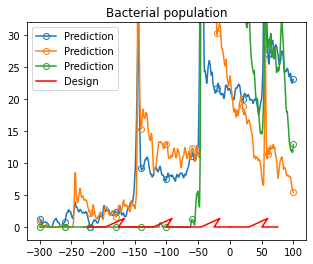

8400 0.017159451730549335 loss =  2561890.5 reg =  1351275.0875850227
Lx, x2, x3, h =  59.77001240604737 50.57709845890153 1.3512750875850226


<Figure size 432x288 with 0 Axes>

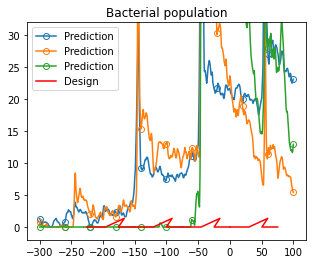

8600 0.01658292207866907 loss =  2551816.25 reg =  1358526.6115004048
Lx, x2, x3, h =  59.77476074060469 50.56436154319238 1.3585266115004049


<Figure size 432x288 with 0 Axes>

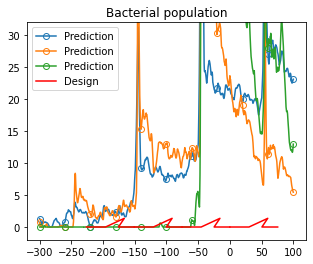

8800 0.016251052729785442 loss =  2540110.0 reg =  1367348.4716162032
Lx, x2, x3, h =  59.77951253043646 50.55144022379673 1.3673484716162032


<Figure size 432x288 with 0 Axes>

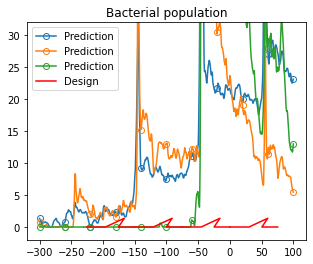

9000 0.016254674643278122 loss =  2527425.0 reg =  1377230.8336971088
Lx, x2, x3, h =  59.784267965853346 50.53846137723353 1.3772308336971089


<Figure size 432x288 with 0 Axes>

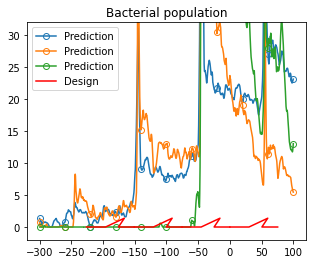

9200 0.016878602094948292 loss =  2520822.5 reg =  1382464.1031077465
Lx, x2, x3, h =  59.786647533744784 50.53199596159128 1.3824641031077465


<Figure size 432x288 with 0 Axes>

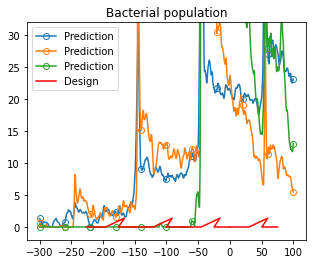

9400 0.016459357924759388 loss =  2514101.75 reg =  1387824.5931870355
Lx, x2, x3, h =  59.78902877484387 50.525564487714604 1.3878245931870354


<Figure size 432x288 with 0 Axes>

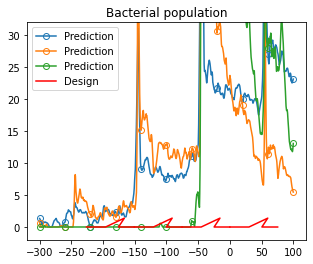

9600 0.015627100132405758 loss =  2507384.5 reg =  1393208.3132505992
Lx, x2, x3, h =  59.791411512422314 50.519165888286395 1.3932083132505992


<Figure size 432x288 with 0 Axes>

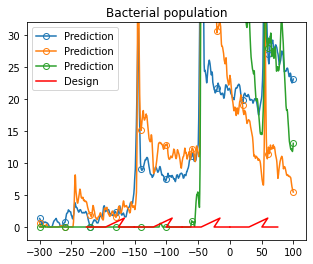

9800 0.01616085972636938 loss =  2500733.0 reg =  1398554.2620812624
Lx, x2, x3, h =  59.79379564478681 50.51280017698002 1.3985542620812623


<Figure size 432x288 with 0 Axes>

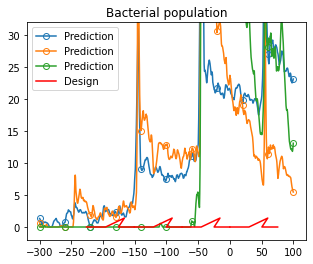

10000 0.01599525660276413 loss =  2494172.0 reg =  1403832.8428572565
Lx, x2, x3, h =  59.79618117246356 50.50646806062959 1.4038328428572566


<Figure size 432x288 with 0 Axes>

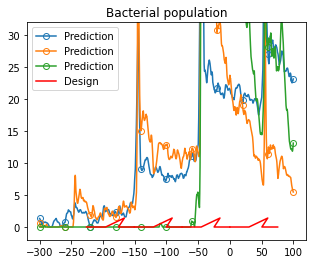

<Figure size 432x288 with 0 Axes>

In [62]:
################################################################
# inverse optimization for 1d
################################################################
n_periods = 4

model = torch.load("catheter_plain_model_1d500", map_location=device)
print(count_params(model))

learning_rate = 0.01
epochs = 10001
step_size = 1000
gamma = 0.5
factor = torch.tensor(1e6)
# x2, x3, h = 40 + theta[0], 40 + theta[1]^2, theta[2]^2
# theta initial condition = 5, sqrt(10), sqrt(3)
# Lx, x2, x3, h
# constraints   
#               0 < Lx 
#               0.4Lx < x3 
#               0 < x2 < Lx
#               0 < h
# Lx=50 + abs(theta[0])
# x1=0.4*Lx
# x2=0.4*Lx + theta[1]
# x3=0.4*Lx + abs(theta[2])
# h = abs(theta[3])
Lx_low = torch.tensor(50.0) 
theta0 = torch.tensor(np.array([50, 5, 10, 2.5], dtype=np.float))
theta = torch.tensor(np.array([50, 5, 10, 2.5], dtype=np.float), requires_grad=True)

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
xx_mask = torch.linspace(-100*(n_periods-1), 100, n_periods*1000+1, dtype=torch.float).to(device)

n_features = 3
n_data = 3
ncx = 200
n_p = n_periods*ncx+1
inputZ = np.zeros((n_data, n_p, n_features))
uf_code = np.array([[1,0,0],[0,1,0],[0,0,1]])
for uf_type in range(n_data):
    inputZ[uf_type,:,:3] = np.outer(np.ones(n_p), uf_code[uf_type, :])
inputZ = torch.tensor(inputZ, dtype=torch.float).to(device)


for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    dLx, dx2, dx3 = torch.abs(theta[0]), theta[1], torch.abs(theta[2])
    Lx  = Lx_low+dLx
    x2, x3, h = 0.4*Lx+dx2,  0.4*Lx+dx3, torch.abs(theta[3])
    x, XC, YC = Theta2Mesh_1d(Lx, x2, x3, h)
    
    
    x = x.repeat(n_data, 1, 1)
    x = torch.cat([x, inputZ], dim=2)
    
    out = torch.clip(model(x).squeeze(), min=0.0)
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))
    # reg = factor*torch.norm(theta[2] - theta0[2])
    reg = factor*torch.norm(theta[3])
    loss_sum = loss + reg
    
    loss_sum.backward()
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item(), "reg = ", reg.item())

        Lx, x2, x3, h = Lx.item(), x2.item(), x3.item(), h.item()
        print("Lx, x2, x3, h = ", x2, x3, h)
        
        bottom_x, bottom_y = np.array([0, 0.4*Lx, x2, x3, Lx]),  np.array([0.0, 0, h, 0, 0.0])
        
    
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(bottom_x, bottom_y, color="r", label="Design")
        for i in range(1, n_periods):
            plt.plot(bottom_x - i*Lx, bottom_y, color="r")
     
        plt.legend()
        plt.ylim(-2.0,32.0)
        plt.show()
        plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")